## El mundo del Wumpus (1/2)

Adaptado de Russell & Norvig (2016), cap. 7.

### Objetivo

Continuamos con el enfoque basado en agentes de la Inteligencia Artificial. Ahora usaremos la representación de conocimiento para construir programas de agentes más sofisticados. En este notebook y el siguiente usaremos la lógica proposicional para mantener una base de conocimiento y un estado de creencias que permita a un agente superar el reto de encontrar el oro en la cueva del Wumpus (sin morir en el intento).

### Secciones

En este notebook desarrollaremos los siguientes aspectos del problema:

1. Presentación del mundo del Wumpus.
* Uso de la lógica proposicional para representar conocimiento.
* Estructura de una base de conocimiento.
* Resolver queries.

### Problema de ejemplo

El siguiente problema se conoce como *El mundo del Wumpus* (Yob, 1975), el cual consiste en una caverna muy oscura, representada por una rejilla de $4\times 4$ rodeada de muros. El agente puede entrar y salir de la caberna por la casilla (0,0) y puede percibir solamente lo que hay en cada casilla en la que se encuentre. En la cueva hay pozos muy profundos, en los que puede caer y morir. Lo peor de todo es que hay un mounstro, conocido como el Wumpus, el cual se comerá vivo al agente si este entra a su casilla. ¿Por qué el agente entraría a un lugar como este? ¡Porque en alguna casilla de la cueva hay un montón de oro!

<img src="./imagenes/ejemplo.png" width="250">

El agente puede guiarse por sus sentidos para navegar en la caberna. En cualquier casilla adyacente (no diagonalmente) a un pozo se percibe una brisa; en cualquier casilla adyacente (no diagonalmente) al Wumpus se percibe un hedor; en la casilla donde se encuentra el oro se percibe un brillo. Además, el agente tiene un arco y (lamentablemente) solo una flecha, con la cual puede matar al Wumpus. Cuando se dispare la flecha, esta seguirá en la dirección en que esté mirando el agente hasta golpear un muro o clavarse en el Wumpus, quien morirá arrojando un desgarrador grito "Aaaaaaarrrrgghhhhh".

**Ejercicio 1:**

De acuerdo con la formulación de entornos hecha durante la clase, ¿cuáles características considera usted que  tiene el *entorno* en este problema?

**Ayuda:** Puede usar el comando `$\checkmark$` para poner un chulito en la opción que desee marcar. 

| Opción 1 | Opción 2 |
| :---: | :---: |
| Completamente observable | $\checkmark$ Parcialmente observable|
| $\checkmark$ Agente único | Multiagente |
| $\checkmark$ Determinista | Estocástico |
| Episódico    | $\checkmark$ secuencial  |
| $\checkmark$ Estático     | dinámico    |
| $\checkmark$ Discreto     | continuo    |
| $\checkmark$ Conocido     | desconocido |

----

La **definición formal del entorno** se hace con base en la definición de las siguientes características:

* **Entorno**: Una cueva representada por una rejilla $4\times 4$ bordeada por muros. El agente siempre comienza en (0, 0) mirando a la derecha. La ubicación del Wumpus se escoge arbitrariamente de manera uniforme en casillas distintas a la inicial. Cualquier casilla distinta de la inicial puede ser un pozo con probabilidad 0.2.

* **Actuadores**: El heroe puede moverse `adelante` por una casilla (no es posible moverse adelante cuando hay un muro), `voltearIzquierda` por 90º, o `voltearDerecha` por 90º. Es posible `agarrar` el oro cuando este está en la casilla ocupada por el heroe. También puede `disparar` la flecha en la dirección en que está mirando, la cual seguirá en linea recta hasta golpear un muro. Finalmente, el agente puede `salir` de la cueva, pero solo desde la casilla inicial.

* **Sensores**: El heroe percibe un `hedor` cuando llega a la casilla donde está el Wumpus o cuando llega a una de las casillas adjacentes (diagonalmente). En las casillas adjacentes a un pozo, percibe una `brisa`. En el cuadro donde está el oro, percibe un `brillo`. Cuando se topa con un muro, percibe un `batacazo`. Finalmente, si el Wumpus muere, el heroe percibe un `grito` desde cualquier casilla.

* **Medida de desempeño**: +1000 por salir de la cueva con el oro; -1000 por caer en un pozo o ser comido por el Wumpus; -1 por cada acción y -10 por usar la flecha. El juego termina cuando el heroe muere o sale de la cueva.


**Implementación del entorno**

Implementaremos el mundo del Wumpus mediante una clase en Python.

Primero cargar librerías y definir unas funciones auxiliares útiles:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np
from random import choice, sample

%matplotlib inline

def truncar(x):
    if x < 0:
        return 0
    elif x > 3:
        return 3
    else:
        return x

def adyacentes(casilla):
    x, y = casilla
    adyacentes = [
        (truncar(x - 1), y), (truncar(x + 1), y),
        (x, truncar(y - 1)), (x, truncar(y + 1))
    ]
    adyacentes = [c for c in adyacentes if c != casilla]
    return adyacentes

Aquí va la clase del mundo del Wumpus:

In [2]:
class wumpus:
    
    def __init__(self):
        casillas = [(x, y) for x in range(4) for y in range(4)]
        casillas_sin_inicial = [casilla for casilla in casillas if casilla != (0,0)]
        self.wumpus = choice(casillas_sin_inicial)
        self.wumpus_vivo = True
        self.hedor = adyacentes(self.wumpus)
        self.oro = choice(casillas)
        self.oro_tomado = False
        self.pozos = sample(casillas_sin_inicial, int(len(casillas_sin_inicial)*0.2))
        aux = []
        for c in self.pozos:
            aux += adyacentes(c)
        self.brisa = aux
        self.heroe = (0, 0)
        self.flecha = True
        self.direccion = 'este'
        self.puntaje = 0
        self.juego_activo = True
        self.grito = False # para determinar cuándo el wumpus grita de agonía
        self.bump = False # para determinar cuándo el agente golpea un muro
    
    def pintar_todo(self):
        # Dibuja el tablero correspondiente al estado
        fig, axes = plt.subplots(figsize=(8, 8))

        # Dibujo el tablero
        step = 1./4
        offset = 0.001
        tangulos = []

        # Borde del tablero
        tangulos.append(patches.Rectangle((0,0),0.998,0.998,\
                                          facecolor='cornsilk',\
                                         edgecolor='black',\
                                         linewidth=2))

        # Creo las líneas del tablero
        for j in range(4):
            locacion = j * step
            # Crea linea horizontal en el rectangulo
            tangulos.append(patches.Rectangle(*[(0, locacion), 1, 0.008],\
                    facecolor='black'))
            # Crea linea vertical en el rectangulo
            tangulos.append(patches.Rectangle(*[(locacion, 0), 0.008, 1],\
                    facecolor='black'))

        for t in tangulos:
            axes.add_patch(t)

        # Cargando imagen del heroe
        arr_img_hero = plt.imread("./imagenes/hero_" + self.direccion + ".png", format='png')
        image_hero = OffsetImage(arr_img_hero, zoom=0.3)
        image_hero.image.axes = axes

        # Cargando imagen del Wumpus
        arr_img_wumpus = plt.imread("./imagenes/wumpus.png", format='png')
        image_wumpus = OffsetImage(arr_img_wumpus, zoom=0.45)
        image_wumpus.image.axes = axes

        # Cargando imagen del hedor
        arr_img_stench = plt.imread("./imagenes/stench.png", format='png')
        image_stench = OffsetImage(arr_img_stench, zoom=0.35)
        image_stench.image.axes = axes

        # Cargando imagen del oro
        arr_img_gold = plt.imread("./imagenes/gold.png", format='png')
        image_gold = OffsetImage(arr_img_gold, zoom=0.25)
        image_gold.image.axes = axes

        # Cargando imagen del pozo
        arr_img_pit = plt.imread("./imagenes/pit.png", format='png')
        image_pit = OffsetImage(arr_img_pit, zoom=0.35)
        image_pit.image.axes = axes

        # Cargando imagen de la brisa
        arr_img_breeze = plt.imread("./imagenes/breeze.png", format='png')
        image_breeze = OffsetImage(arr_img_breeze, zoom=0.35)
        image_breeze.image.axes = axes

        offsetX = 0.125
        offsetY = 0.125

        for casilla in self.pozos:
            # Pintando un pozo
            X, Y = casilla
            ab = AnnotationBbox(
                image_pit, 
                [(X*step) + offsetX, (Y*step) + offsetY], 
                frameon=False)
            axes.add_artist(ab)

        for casilla in self.hedor:
            # Pintando el hedor
            X, Y = casilla
            ab = AnnotationBbox(
                image_stench, 
                [(X*step) + offsetX, (Y*step) + offsetY - 0.075], 
                frameon=False)
            axes.add_artist(ab)

        for casilla in self.brisa:
            # Pintando la brisa
            X, Y = casilla
            ab = AnnotationBbox(
                image_breeze, 
                [(X*step) + offsetX, (Y*step) + offsetY + 0.075], 
                frameon=False)
            axes.add_artist(ab)

        # Pintando el wumpus
        X, Y = self.wumpus
        ab = AnnotationBbox(
            image_wumpus, 
            [(X*step) + offsetX, (Y*step) + offsetY], 
            frameon=False)
        axes.add_artist(ab)

        # Pintando el heroe
        X, Y = self.heroe
        ab = AnnotationBbox(
            image_hero, 
            [(X*step) + offsetX, (Y*step) + offsetY], 
            frameon=False)
        axes.add_artist(ab)

        # Pintando el oro
        X, Y = self.oro
        ab = AnnotationBbox(
            image_gold, 
            [(X*step) + offsetX, (Y*step) + offsetY], 
            frameon=False)
        axes.add_artist(ab)

        axes.axis('off')
        return axes
        
    def pintar_casilla(self):
        if self.juego_activo:
            # Dibuja el tablero correspondiente al estado
            fig, axes = plt.subplots(figsize=(8, 8))

            # Dibujo el tablero
            step = 1./4
            offset = 0.001
            tangulos = []

            # Borde del tablero
            tangulos.append(patches.Rectangle((0,0),0.998,0.998,\
                                              facecolor='cornsilk',\
                                             edgecolor='black',\
                                             linewidth=2))

            # Creo las líneas del tablero
            for j in range(4):
                locacion = j * step
                # Crea linea horizontal en el rectangulo
                tangulos.append(patches.Rectangle(*[(0, locacion), 1, 0.008],\
                        facecolor='black'))
                # Crea linea vertical en el rectangulo
                tangulos.append(patches.Rectangle(*[(locacion, 0), 0.008, 1],\
                        facecolor='black'))

            for t in tangulos:
                axes.add_patch(t)

            # Cargando imagen del heroe
            arr_img_hero = plt.imread("./imagenes/hero_" + self.direccion + ".png", format='png')
            image_hero = OffsetImage(arr_img_hero, zoom=0.3)
            image_hero.image.axes = axes

            # Cargando imagen del Wumpus
            arr_img_wumpus = plt.imread("./imagenes/wumpus.png", format='png')
            image_wumpus = OffsetImage(arr_img_wumpus, zoom=0.45)
            image_wumpus.image.axes = axes

            # Cargando imagen del hedor
            arr_img_stench = plt.imread("./imagenes/stench.png", format='png')
            image_stench = OffsetImage(arr_img_stench, zoom=0.35)
            image_stench.image.axes = axes

            # Cargando imagen del oro
            arr_img_gold = plt.imread("./imagenes/gold.png", format='png')
            image_gold = OffsetImage(arr_img_gold, zoom=0.25)
            image_gold.image.axes = axes

            # Cargando imagen del pozo
            arr_img_pit = plt.imread("./imagenes/pit.png", format='png')
            image_pit = OffsetImage(arr_img_pit, zoom=0.35)
            image_pit.image.axes = axes

            # Cargando imagen de la brisa
            arr_img_breeze = plt.imread("./imagenes/breeze.png", format='png')
            image_breeze = OffsetImage(arr_img_breeze, zoom=0.35)
            image_breeze.image.axes = axes

            offsetX = 0.125
            offsetY = 0.125
            
            casilla = self.heroe

            if casilla in self.pozos:
                # Pintando un pozo
                X, Y = casilla
                ab = AnnotationBbox(
                    image_pit, 
                    [(X*step) + offsetX, (Y*step) + offsetY], 
                    frameon=False)
                axes.add_artist(ab)

            if casilla in self.hedor:
                # Pintando el hedor
                X, Y = casilla
                ab = AnnotationBbox(
                    image_stench, 
                    [(X*step) + offsetX, (Y*step) + offsetY - 0.075], 
                    frameon=False)
                axes.add_artist(ab)

            if casilla in self.brisa:
                # Pintando la brisa
                X, Y = casilla
                ab = AnnotationBbox(
                    image_breeze, 
                    [(X*step) + offsetX, (Y*step) + offsetY + 0.075], 
                    frameon=False)
                axes.add_artist(ab)

            if casilla == self.wumpus:
                # Pintando el wumpus
                X, Y = self.wumpus
                ab = AnnotationBbox(
                    image_wumpus, 
                    [(X*step) + offsetX, (Y*step) + offsetY], 
                    frameon=False)
                axes.add_artist(ab)

            # Pintando el heroe
            X, Y = casilla
            ab = AnnotationBbox(
                image_hero, 
                [(X*step) + offsetX, (Y*step) + offsetY], 
                frameon=False)
            axes.add_artist(ab)

            if casilla == self.oro:
                # Pintando el oro
                X, Y = self.oro
                ab = AnnotationBbox(
                    image_gold, 
                    [(X*step) + offsetX, (Y*step) + offsetY], 
                    frameon=False)
                axes.add_artist(ab)

            axes.axis('off')
            return axes
        else:
            return None
    
    def transicion(self, accion):
        if self.juego_activo:
            self.grito = False
            self.bump = False
            self.puntaje -= 1
            if accion == 'agarrar':
                if (self.oro == self.heroe) and (self.oro_tomado == False):
                    self.puntaje += 1000
            elif accion == 'adelante':
                x, y = self.heroe 
                if self.direccion == 'este':
                    self.heroe = (truncar(x + 1), y)
                    self.bump = True if truncar(x + 1) == x else False
                if self.direccion == 'oeste':
                    self.heroe = (truncar(x - 1), y)
                    self.bump = True if truncar(x - 1) == x else False
                if self.direccion == 'norte':
                    self.heroe = (x, truncar(y + 1))
                    self.bump = True if truncar(y + 1) == y else False
                if self.direccion == 'sur':
                    self.heroe = (x, truncar(y - 1))
                    self.bump = True if truncar(y - 1) == y else False
            elif accion == 'salir':
                if self.heroe == (0, 0):
                    self.juego_activo = False
                    print("¡Juego terminado!")
                    print("Puntaje:", self.puntaje)
                    self.pintar_todo()
            elif accion == 'voltearIzquierda':
                if self.direccion == 'este':
                    self.direccion = 'norte'
                elif self.direccion == 'oeste':
                    self.direccion = 'sur'
                elif self.direccion == 'norte':
                    self.direccion = 'oeste'
                elif self.direccion == 'sur':
                    self.direccion = 'este'
            elif accion == 'voltearDerecha':
                if self.direccion == 'este':
                    self.direccion = 'sur'
                elif self.direccion == 'oeste':
                    self.direccion = 'norte'
                elif self.direccion == 'norte':
                    self.direccion = 'este'
                elif self.direccion == 'sur':
                    self.direccion = 'oeste'
            elif accion == 'disparar':
                if self.flecha:
                    self.flecha = False
                    if self.wumpus_vivo:
                        x_wumpus, y_wumpus = self.wumpus
                        x_heroe, y_heroe = self.heroe
                        if (self.direccion == 'este') and ((x_heroe < x_wumpus) and (y_heroe == y_wumpus)):
                            self.wumpus_vivo = False
                            self.grito = True
                        if (self.direccion == 'oeste') and ((x_heroe > x_wumpus) and (y_heroe == y_wumpus)):
                            self.wumpus_vivo = False
                            self.grito = True
                        if (self.direccion == 'norte') and ((y_heroe < y_wumpus) and (x_heroe == x_wumpus)):
                            self.wumpus_vivo = False
                            self.grito = True
                        if (self.direccion == 'sur') and ((y_heroe > y_wumpus) and (x_heroe == x_wumpus)):
                            self.wumpus_vivo = False
                            self.grito = True
            else:
                print('¡Acción incorrecta!')
            if self.heroe in self.pozos:
                self.puntaje -= 1000
                self.juego_activo = False
                print("¡Juego terminado!")
                print("El héroe a caido en un pozo")
                print("Puntaje:", self.puntaje)
                self.pintar_todo()
            elif (self.heroe == self.wumpus) and self.wumpus_vivo:
                self.puntaje -= 1000
                self.juego_activo = False
                print("¡Juego terminado!")
                print("El héroe ha sido devorado por el Wumpus")
                print("Puntaje:", self.puntaje)
                self.pintar_todo()
        else:
            print("El juego ha terminado.")


Ahora la función para recibir la información sensorial de la casilla en la cual se encuentra el héroe:

In [3]:
def percibir(mundo):
    
    # Lista de sensores [hedor, brisa, brillo, batacazo, grito]
    hedor = 'hedor' if mundo.heroe in mundo.hedor else None
    brisa = 'brisa' if mundo.heroe in mundo.brisa else None
    brillo = 'brillo' if mundo.heroe == mundo.oro else None
    batacazo = 'batacazo' if mundo.bump else None
    grito = 'grito' if mundo.grito else None
    return [hedor, brisa, brillo, batacazo, grito]

Inicializamos el mundo y percibimos lo que hay en la primera casilla:

[None, None, None, None, None]

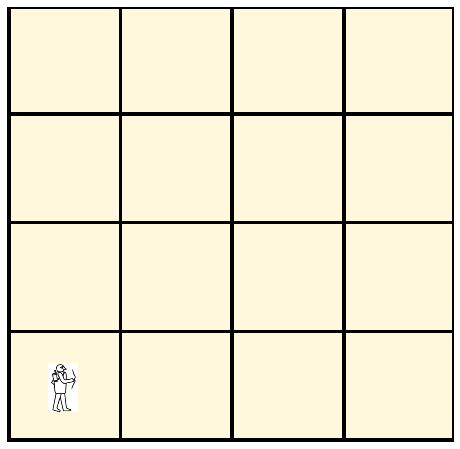

In [4]:
W = wumpus()
W.pintar_casilla()
percibir(W)

Un paso arriesgado en la oscuridad:

['hedor', None, 'brillo', None, None]

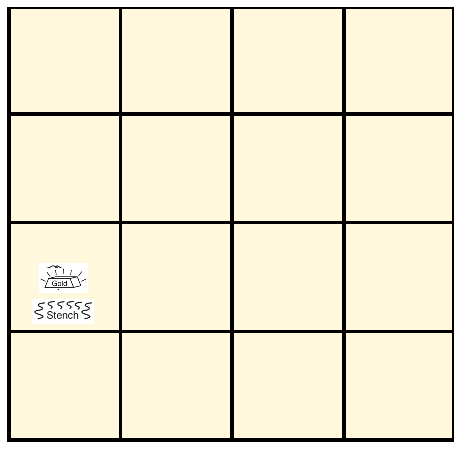

In [5]:
W.transicion('voltearIzquierda')
W.transicion('adelante')
W.pintar_casilla()
percibir(W)

**Ejercicio 2:**

Escriba el código para que el héroe avance dos casillas a la derecha y una arriba, percibiendo el entorno a cada paso.

**Respuesta:**

¡Juego terminado!
El héroe ha sido devorado por el Wumpus
Puntaje: -1004
[None, 'brisa', None, None, None]
El juego ha terminado.
[None, 'brisa', None, None, None]
El juego ha terminado.
El juego ha terminado.
[None, 'brisa', None, None, None]


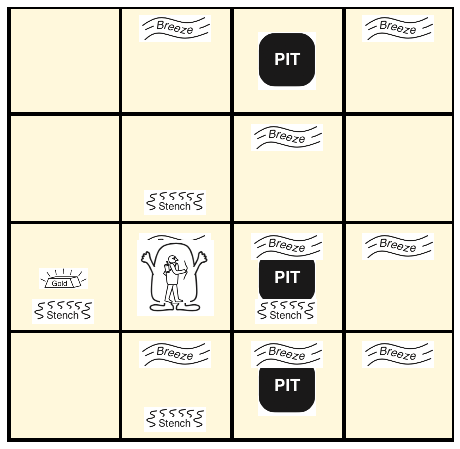

In [6]:
W.transicion('voltearDerecha')
W.transicion('adelante')
print(percibir(W))
W.transicion('adelante')
print(percibir(W))
W.transicion('voltearIzquierda')
W.transicion('adelante')
print(percibir(W))
W.pintar_casilla()

---

## Agentes basados en el conocimiento

Lo primero que necesita el agente es poder decidir, con base en la información sensorial a su disposición, cuáles casillas son seguras para transitar. Para lograr esto es necesario que el agente sea capaz de:

1. Representar las reglas del mundo del Wumpus.
* Hacer inferencias para combinar la información sensorial con las reglas del mundo.

En este notebook nuestro objetivo es definir una función `ASK(KB, Segura(x, y), True)` que nos permita determinar si a partir de la base de conocimiento `KB`, es posible afirmar que la casilla $(x,y)$ es segura. En el siguiente notebook completaremos la definición del agente para solucionar el mundo del Wumpus.

### Representación del mundo del Wumpus en lógica proposicional

Debemos representar las letras proposicionales, las cuales cruzan la información sobre cada casilla. En nuestro problema esta información consistirá en: la columna (`x`), la fila (`y`), y el tipo de información. Definimos:

* `P(x, y, 0)` es verdadero sii el agente cree que la casilla $(x,y)$ es segura para transitar.
* `P(x, y, 1)` es verdadero sii en la casilla $(x,y)$ se percibe una brisa.
* `P(x, y, 2)` es verdadero sii el agente cree que en la casilla $(x,y)$ hay un pozo.

**Importante:** Se ha omitido mucha información del mundo con el propósito de llegar a una función `ASK` mínimamente funcional en el tiempo previsto para la clase.

La siguiente tabla puede ser útil para futuras referencias y puede irse completando a medida que se vaya avanzando en la representación:

| Información | Número de codificación |
| :---: | :---: |
| Casilla segura     | 0    |
| Casilla con brisa     | 1 |
| Casilla con pozo     | 2 |

Para representar una letra proposicional mediante un solo caracter, usaremos las siguientes funciones:

In [7]:
class codigos:
    
    # Clase para agrupar las funciones de codificación
    # de letras proposicionales
    
    def __init__(self, Nf, Nc, No):
        self.Nf = Nf # Número de filas
        self.Nc = Nc # Número de columnas
        self.No = No # Número de opciones de información
        
    def codifica(self, f, c, Nf, Nc):
        # Funcion que codifica la fila f y columna c
        assert((f >= 0) and (f <= Nf - 1)), 'Primer argumento incorrecto! Debe ser un numero entre 0 y ' + str(Nf) - 1  + "\nSe recibio " + str(f)
        assert((c >= 0) and (c <= Nc - 1)), 'Segundo argumento incorrecto! Debe ser un numero entre 0 y ' + str(Nc - 1)  + "\nSe recibio " + str(c)
        n = Nc * f + c
        # print(u'Número a codificar:', n)
        return n

    def decodifica(self, n, Nf, Nc):
        # Funcion que codifica un caracter en su respectiva fila f y columna c de la tabla
        assert((n >= 0) and (n <= Nf * Nc - 1)), 'Codigo incorrecto! Debe estar entre 0 y ' + str(Nf * Nc - 1) + "\nSe recibio " + str(n)
        f = int(n / Nc)
        c = n % Nc
        return f, c

    def P(self, f, c, o):
        # Funcion que codifica tres argumentos
        assert((f >= 0) and (f <= self.Nf - 1)), 'Primer argumento incorrecto! Debe ser un numero entre 0 y ' + str(Nf - 1) + "\nSe recibio " + str(f)
        assert((c >= 0) and (c <= self.Nc - 1)), 'Segundo argumento incorrecto! Debe ser un numero entre 0 y ' + str(Nc - 1) + "\nSe recibio " + str(c)
        assert((o >= 0) and (o <= self.No - 1)), 'Tercer argumento incorrecto! Debe ser un numero entre 0 y ' + str(No - 1)  + "\nSe recibio " + str(o)
        v1 = self.codifica(f, c, self.Nf, self.Nc)
        v2 = self.codifica(v1, o, self.Nf * self.Nc, self.No)
        codigo = chr(256 + v2)
        return codigo

    def Pinv(self, codigo):
        # Funcion que codifica un caracter en su respectiva fila f, columna c y objeto o
        x = ord(codigo) - 256
        v1, o = self.decodifica(x, self.Nf * self.Nc, self.No)
        f, c = self.decodifica(v1, self.Nf, self.Nc)
        return f, c, o
    
    def imprime_formula(self, fml):
        for c in fml:
            if c in ['Y', '>', '-']:
                print(c, end="")
            else:
                x, y, o = self.Pinv(c)
                if o == 0:
                    print("Segura" + str((x, y)), end="")
                if o == 1:
                    print("Brisa" + str((x, y)), end="")
                if o == 2:
                    print("Pozo" + str((x, y)), end="")
                if o == 3:
                    print("Hedor" + str((x, y)), end="")
                if o == 4:
                    print("Wumpus" + str((x, y)), end="")

El caracter de la letra proposicional la cual representa el hecho de que en la casilla $(1,2)$ se percibe una brisa es:

In [8]:
# Se crea objeto de codificación
cods = codigos(4, 4, 3)
# Se imprime el caracter de la casilla (1,2) sobre percibir brisa
cods.P(1, 2, 1)

'ē'

**Ejercicio 3:**

Encuentre los caracteres de las letras proposicionales para la siguiente información:

* En la casilla $(1, 0)$ se percibe una brisa.
* El agente cree que la casilla $(1, 1)$ tiene un pozo.
* El agente cree que la casilla $(0, 1)$ es segura.

**Respuesta:**

In [9]:
print(cods.P(1, 0, 1)) # En la casilla (1,0) se percibe una brisa
print(cods.P(1, 1, 2)) # La casilla (1,1) tiene un pozo
print(cods.P(0, 1, 0)) # La casilla (0,1) es segura

č
đ
ă


---

Ahora usamos fórmulas de la lógica proposicional para representar aspectos del mundo. Comenzamos con una parte de la información sobre la relación entre los pozos y la brisa. Necesitamos incluir en la base de conocimiento las siguientes fórmulas:

1. $P(4,4,2) \to \bigl(P(3,4,1)\wedge P(4,3,1)\bigr)$ *(si hay un  pozo en $(4,4)$, se percibe una brisa en $(3,4)$ y en $(4,3)$)*
* $P(1,1,2) \to \bigl( P(0,1,1)\wedge P(2,1,1)\wedge P(1,0,1)\wedge P(1,2,1)\bigr)$ *(si hay un  pozo en $(1,1)$, se percibe una brisa en $(0,1)$, en $(2,1)$, en $(1,0)$ y en $(1,2)$)*
* $\vdots$

Con el fin de implementar los algoritmos de búsqueda, usaremos fórmulas en forma 'pseudo' cláusulas de Horn (ver diapositivas sesión 7), por lo que reescribimos las anteriores fórmulas así:

*Conjunto de fórmulas que expresan la fórmula (1) arriba:*
* $\neg P(3,4,1)\to \neg P(4,4,2)$
* $\neg P(4,4,1)\to \neg P(4,4,2)$

*Conjunto de fórmulas que expresan la fórmula (2) arriba:*
* $\neg P(0,1,1)\to \neg P(1,1,2)$
* $\neg P(2,1,1)\to \neg P(1,1,2)$
* $\neg P(1,0,1)\to \neg P(1,1,2)$
* $\neg P(2,1,1)\to \neg P(1,1,2)$

**Nota:** Sobre la otra parte de la información sobre la relación entre los pozos y la brisa, ver ejercicio 7 más abajo.

**Ejercicio 4:**

Escriba un código que genere todas las implicaciones sobre pozos.

**Respuesta:**

Una posible respuesta es la siguiente:

In [10]:
n = 1
formulas_brisa = []
for x in range(n):
    for y in range(n):
        for p in adyacentes((x,y)):
            i, j = p
            formulas_brisa.append("-" + cods.P(i, j, 1) + ">-" + cods.P(x, y, 2))

print(formulas_brisa)
for fml in formulas_brisa:
    cods.imprime_formula(fml)
    print("")

['-č>-Ă', '-Ą>-Ă']
-Brisa(1, 0)>-Pozo(0, 0)
-Brisa(0, 1)>-Pozo(0, 0)


---

**Ejercicio 5:**

Escriba un código para representar que si en una casilla no hay un pozo, entonces es segura. 

**Respuesta:**

Una posible manera de hacer eso es la siguiente:

In [11]:
for x in range(n):
    for y in range(n):
        formulas_brisa.append("-" + cods.P(x, y, 2) + ">" + cods.P(x, y, 0))

print(formulas_brisa)
for fml in formulas_brisa:
    cods.imprime_formula(fml)
    print("")

['-č>-Ă', '-Ą>-Ă', '-Ă>Ā']
-Brisa(1, 0)>-Pozo(0, 0)
-Brisa(0, 1)>-Pozo(0, 0)
-Pozo(0, 0)>Segura(0, 0)


---

**Nota 1:** Si desea repasar bien este tipo de codificación y su uso en la implementación de fórmulas de la lógica proposicional, puede consultar el notebook `Codificacion_letras`.

**Nota 2:** Ver diapositivas de la sesión 7 sobre fórmulas en forma 'pseudo' cláusulas de Horn y estructura de una base de conocimiento.


### Base de conocimiento para el mundo del Wumpus

Una base de conocimiento es una estructura sobre la cual se pueden hacer consultas de objetivos. En un momento volveremos sobre el procedimiento usado para las consultas. Por ahora presentaremos la base de conocimiento. Esta tiene dos partes: los datos, que son una lista de literales; y las reglas, que son fórmulas en forma 'pseudo' cláusulas de Horn (ver diapositivas sesión 7). Sobre estas dos partes montaremos una estructura de **problema**, como el que hemos visto en sesiones anteriores, la cual incluye las `acciones_aplicables` (en este caso las `reglas_aplicables`), la `transicion` y el `test_objetivo`.

In [12]:
class lp_query:
    
    def __init__(self, base_conocimiento_lista, cods):
   
        # Con base en la lista de cláusulas en la base de 
        # conocimiento, crea un diccionario optimizado para 
        # la búsqueda
        # Input: base_conocimiento_lista, que es una lista de fórmulas 'pseudo' cláusulas de Horn
        #        cods, un objeto de clase codigos
        self.base_conocimiento = {'datos':[], 'reglas':{}}
        for formula in base_conocimiento_lista:
            indice_conectivo = formula.find('>')
            if indice_conectivo > 0:
                cuerpo = formula[:indice_conectivo]
                cabeza = formula[indice_conectivo + 1:]
                try: 
                    self.base_conocimiento['reglas'][cabeza].append(cuerpo)        
                except:
                    self.base_conocimiento['reglas'][cabeza] = [cuerpo]
            else:
                try:
                    if literal not in base.base_conocimiento['datos']:
                        base.base_conocimiento['datos'].append(literal)
                except:
                    self.base_conocimiento['datos'] = [cuerpo]
        self.cods = cods
    
    def visualizar(self):
        print("Datos:")
        for l in self.base_conocimiento['datos']:
            self.cods.imprime_formula(l)
            print('')
        print("\nReglas:")
        for k in self.base_conocimiento['reglas'].keys():
            for c in self.base_conocimiento['reglas'][k]:
                self.cods.imprime_formula(c)
                print(">", end="")
                self.cods.imprime_formula(k)
                print(" ")
        
    def reglas_aplicables(self, head):
        # Devuelve una lista de cláusulas de Horn cuya cabeza
        # es el estado/literal
        # Input: head, que es un literal
        # Output: lista de cláusulas de Horn
        try: 
            cuerpo = self.base_conocimiento['reglas'][head]
        except:
            cuerpo = []

        return cuerpo

    def transicion(self, head, body):
        # Devuelve una lista con los literales en la clausula
        # Input: head, que es un literal se asume que head:- body es una regla
        #        body, que es una lista de cláusulas de Horn
        return body.split('Y')
    
    def test_objetivo(self, literal):
        # Devuelve True/False dependiendo si el literal
        # está en la base de datos
        # Input: literal
        # Output: True/False
        literales = self.base_conocimiento['datos']
        return True if literal in literales else False

In [13]:
Base_wumpus = lp_query(formulas_brisa, cods)
print(Base_wumpus.base_conocimiento)
print("****************")
print("Misma base de conocimiento pero más legible:")
Base_wumpus.visualizar()

{'datos': [], 'reglas': {'-Ă': ['-č', '-Ą'], 'Ā': ['-Ă']}}
****************
Misma base de conocimiento pero más legible:
Datos:

Reglas:
-Brisa(1, 0)>-Pozo(0, 0) 
-Brisa(0, 1)>-Pozo(0, 0) 
-Pozo(0, 0)>Segura(0, 0) 


Definimos una función para actualizar una base de conocimiento con una fórmula:

In [14]:
def TELL(base, formula):
    indice_conectivo = formula.find('>')
    if indice_conectivo > 0:
        cuerpo = formula[:indice_conectivo]
        cabeza = formula[indice_conectivo + 1:]
        try:
            if cuerpo not in base.base_conocimiento['reglas'][cabeza]:
                base.base_conocimiento['reglas'][cabeza].append(cuerpo)
        except:
            base.base_conocimiento['reglas'][cabeza] = [cuerpo]
    else:
        lista_hechos = formula.split('Y')
        for literal in lista_hechos:
            try:
                if literal not in base.base_conocimiento['datos']:
                    base.base_conocimiento['datos'].append(literal)
            except:
                base.base_conocimiento['datos'] = [literal]

In [18]:
literal = '-' + cods.P(0,0,1)
TELL(Base_wumpus, literal)
Base_wumpus.visualizar()

Datos:
-Brisa(0, 1)
-Brisa(0, 0)

Reglas:
-Brisa(1, 0)>-Pozo(0, 0) 
-Brisa(0, 1)>-Pozo(0, 0) 
-Pozo(0, 0)>Segura(0, 0) 


### Inferencias y queries

Ya estamos casi listos para ayudarle al héroe a determinar si una casilla es segura para transitar o no. Todo lo que debemos hacer es implementar el algoritmo de backward chaining, mediante el cual se construye la función `ASK`.

**Ejercicio 6:**

Implemente la función `ASK` usando el pseudo código de las diapositivas de la sesión 7.

**Respuesta:**

Una posible implementación es al siguiente:

In [19]:
def ASK(objetivo, valor:bool, base):
    print("Se pregunta por: ", end="")
    cods.imprime_formula(objetivo)
    print(" es", valor)
    ask = True if (and_or_graph_search(objetivo, base) != 'failure') else False
    return (ask == valor)

def and_or_graph_search(objetivo, base):
    return or_search(objetivo, base, [])

def or_search(head, base, camino):
    if base.test_objetivo(head):
        return 'success'
    elif head in camino:
        return 'failure'
    reglas = base.reglas_aplicables(head)
    if not reglas:
        return 'failure'
    for regla in reglas:
        plan = and_search(base.transicion(head, regla), base, [head] + camino)
        if plan != 'failure':
            return 'success'    
    return 'failure'

def and_search(literales, base, camino):
    for literal in literales:
        plan = or_search(literal, base, camino)
        if plan == 'failure':
            return 'failure'
    return 'success'

In [21]:
# Pruebe su código con el siguiente query
ASK(cods.P(0,0,0), True, Base_wumpus) # Debe responder True

Se pregunta por: Segura(0, 0) es True


True

In [23]:
# Pruebe su código con el siguiente query
ASK("-" + cods.P(1,1,0), False, Base_wumpus) # Debe responder True

Se pregunta por: -Segura(1, 1) es False


True

---

**Ejercicio 7:**

Vuelva a la diapositiva 5 de la sesión 7 y considere nuevamente el razonamiento hecho por el agente para determinar que el Wumpus está en la casilla $(0,2)$. Observe que para lograr hacer esta inferencia se requiere usar la siguiente regla:

(1) $Hedor(0,1)\to\bigl(Wumpus(0,0)\vee Wumpus(1,1)\vee Wumpus(0,2)\bigr)$

Esta fórmula se combina con los datos $\neg Wumpus(0,0)$ y $\neg Wumpus(1,1)$ para deducir $Wumpus(0,2)$.

Ahora, recuerde que en la base de conocimiento usamos solo fórmulas en forma 'pseudo' cláusulas de Horn, y (1) no está en el formato adecuado. Para poder implementar el razonamiento, es necesario usar las siguientes fórmulas:

(2) $\bigl(Hedor(0,1)\wedge\neg Wumpus(0,0)\wedge\neg Wumpus(1,1)\bigr)\to Wumpus(0,2)$

(3) $\bigl(Hedor(0,1)\wedge\neg Wumpus(1,1)\wedge\neg Wumpus(0,2)\bigr)\to Wumpus(0,0)$

(4) $\bigl(Hedor(0,1)\wedge\neg Wumpus(0,0)\wedge\neg Wumpus(0,2)\bigr)\to Wumpus(1,1)$

Implemente las fórmulas (2)-(4) e inclúyalas en la base de conocimiento. Luego incluya solo los datos que se obtienen de las percepciones consideradas en la diapositiva 5 de la sesión 7. Corra la función `ASK` para determinar si el Wumpus está en la casilla $(0,2)$.

**Respuesta:**

Requerimos extender la codificiación inicial a esta:

| Información | Número de codificación |
| :---: | :---: |
| Casilla segura     | 0    |
| Casilla con brisa     | 1 |
| Casilla con pozo     | 2 |
| Casilla con hedor     | 3 |
| Casilla con Wumpus     | 4 |

También hay que modificar el método `imprime_formula` de la clase codificación para visualizar correctamente la información.

Una posible implementación es la siguiente:

In [24]:
cods = codigos(4,4,5) # Observe que se cambia el número de tipos de información a 5
formulas = []
f2 = cods.P(0,1,3) + "Y-" + cods.P(0,0,4) + "Y-" + cods.P(1,1,4) + ">" + cods.P(0,2,4)
formulas.append(f2)
f3 = cods.P(0,1,3) + "Y-" + cods.P(1,1,4) + "Y-" + cods.P(0,2,4) + ">" + cods.P(0,0,4)
formulas.append(f3)
f4 = cods.P(0,1,3) + "Y-" + cods.P(0,0,4) + "Y-" + cods.P(0,2,4) + ">" + cods.P(1,1,4)
formulas.append(f4)
Base_wumpus = lp_query(formulas, cods)
Base_wumpus.visualizar()

Datos:

Reglas:
Hedor(0, 1)Y-Wumpus(0, 0)Y-Wumpus(1, 1)>Wumpus(0, 2) 
Hedor(0, 1)Y-Wumpus(1, 1)Y-Wumpus(0, 2)>Wumpus(0, 0) 
Hedor(0, 1)Y-Wumpus(0, 0)Y-Wumpus(0, 2)>Wumpus(1, 1) 


Se incluyen las fórmulas de Wumpus:

In [25]:
n = 2
formulas_wumpus = []
for x in range(n):
    for y in range(n):
        for p in adyacentes((x,y)):
            i, j = p
            formulas_wumpus.append("-" + cods.P(i, j, 3) + ">-" + cods.P(x, y, 4))

Base_wumpus = lp_query(formulas + formulas_wumpus, cods)
Base_wumpus.visualizar()

Datos:

Reglas:
Hedor(0, 1)Y-Wumpus(0, 0)Y-Wumpus(1, 1)>Wumpus(0, 2) 
Hedor(0, 1)Y-Wumpus(1, 1)Y-Wumpus(0, 2)>Wumpus(0, 0) 
Hedor(0, 1)Y-Wumpus(0, 0)Y-Wumpus(0, 2)>Wumpus(1, 1) 
-Hedor(1, 0)>-Wumpus(0, 0) 
-Hedor(0, 1)>-Wumpus(0, 0) 
-Hedor(1, 1)>-Wumpus(0, 1) 
-Hedor(0, 0)>-Wumpus(0, 1) 
-Hedor(0, 2)>-Wumpus(0, 1) 
-Hedor(0, 0)>-Wumpus(1, 0) 
-Hedor(2, 0)>-Wumpus(1, 0) 
-Hedor(1, 1)>-Wumpus(1, 0) 
-Hedor(0, 1)>-Wumpus(1, 1) 
-Hedor(2, 1)>-Wumpus(1, 1) 
-Hedor(1, 0)>-Wumpus(1, 1) 
-Hedor(1, 2)>-Wumpus(1, 1) 


Se incluyen los hechos:

In [26]:
# Datos sobre la casilla inicial
TELL(Base_wumpus, "-" + cods.P(0,0,1))
TELL(Base_wumpus, "-" + cods.P(0,0,2))
TELL(Base_wumpus, "-" + cods.P(0,0,3))
# Datos sobre la casilla (1,0)
TELL(Base_wumpus, cods.P(1,0,1))
TELL(Base_wumpus, "-" + cods.P(1,0,2))
TELL(Base_wumpus, "-" + cods.P(1,0,3))
# Datos sobre la casilla (0,1)
TELL(Base_wumpus, "-" + cods.P(0,1,1))
TELL(Base_wumpus, "-" + cods.P(0,1,2))
TELL(Base_wumpus, cods.P(0,1,3))
Base_wumpus.visualizar()

Datos:
-Brisa(0, 0)
-Pozo(0, 0)
-Hedor(0, 0)
Brisa(1, 0)
-Pozo(1, 0)
-Hedor(1, 0)
-Brisa(0, 1)
-Pozo(0, 1)
Hedor(0, 1)

Reglas:
Hedor(0, 1)Y-Wumpus(0, 0)Y-Wumpus(1, 1)>Wumpus(0, 2) 
Hedor(0, 1)Y-Wumpus(1, 1)Y-Wumpus(0, 2)>Wumpus(0, 0) 
Hedor(0, 1)Y-Wumpus(0, 0)Y-Wumpus(0, 2)>Wumpus(1, 1) 
-Hedor(1, 0)>-Wumpus(0, 0) 
-Hedor(0, 1)>-Wumpus(0, 0) 
-Hedor(1, 1)>-Wumpus(0, 1) 
-Hedor(0, 0)>-Wumpus(0, 1) 
-Hedor(0, 2)>-Wumpus(0, 1) 
-Hedor(0, 0)>-Wumpus(1, 0) 
-Hedor(2, 0)>-Wumpus(1, 0) 
-Hedor(1, 1)>-Wumpus(1, 0) 
-Hedor(0, 1)>-Wumpus(1, 1) 
-Hedor(2, 1)>-Wumpus(1, 1) 
-Hedor(1, 0)>-Wumpus(1, 1) 
-Hedor(1, 2)>-Wumpus(1, 1) 


In [27]:
ASK(cods.P(0,2,4), True, Base_wumpus)

Se pregunta por: Wumpus(0, 2) es True


True

---

### En este notebook usted aprendió

* El mundo del Wumpus.
* Uso de la lógica proposicional para representar conocimiento.
* Estructura de una base de conocimiento.
* Resolver queries mediante backward chaining sobre pseudo cláusulas de Horn.